In [3]:
import tensorflow as tf
import itertools

import numpy as np
import matplotlib.pyplot as plt
tf.enable_eager_execution()

In [4]:
def build_net():
    return tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation=tf.nn.selu, return_sequences=True),
#         tf.keras.layers.Dense(64, activation=tf.nn.selu),
#         tf.keras.layers.Dense(64, activation=tf.nn.selu),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Flatten()
    ])

In [5]:
def discount_rewards(rewards, gamma):
    rewards = reversed(tf.unstack(rewards))
    return tf.stack(list(reversed(list(itertools.accumulate(rewards, lambda x, y: x*gamma+y)))), axis=0)
#     return tf.expand_dims(tf.accumulate_n(lambda x, y: x+gamma*y, tf.transpose(rewards)), -1)

class Critics():
    """
    Train an ensemble of critics at different time scales.
    Same input (extension - could be different inputs...)
    Different targets
    """
    # oh shit! this is going to turn into something like GVFs!?!?!? sick!
    def __init__(self, n_critics):
        self.fns = [build_net() for _ in range(n_critics)]
    
    def __call__(self, state):
        # want to calculate this more efficiently.
        # maybe using heirarchical LSTMs? or GVFs/cumulants!?
        return tf.add_n([fn(state) for fn in self.fns])
    
    def get_loss(self, state, r):
        vs = [fn(state) for fn in self.fns]
        rs = [discount_rewards(r, g) for g in [0.999, 0.99, 0.9]]
        return tf.add_n([tf.losses.mean_squared_error(r, v) for r, v in zip(vs, rs)])

In [6]:
critics = Critics(3)

states = tf.random_normal([5, 20, 3])
rs = tf.random_normal([5, 20])
v = critics(states)
loss = critics.get_loss(states, rs)

In [7]:
loss

<tf.Tensor: id=13767, shape=(), dtype=float32, numpy=8.536299>

In [8]:
# So I should be able to use this in a vanilla A2C framework?
# Does it help!?

# Ok, but want HRL! How can we choose actions in a heirarchical manner?

In [64]:
def discount_rewards(rewards, gamma):
    rewards = tf.unstack(rewards)
    return tf.stack(list(reversed(list(itertools.accumulate(list(reversed(rewards)), lambda x, y: x+gamma*y)))), axis=0)

In [65]:
x = tf.linspace(0.0,12.0, 1000)
y = tf.sin(x*3)+tf.sin(x*4+0.2) + tf.sin(x*5+0.5)

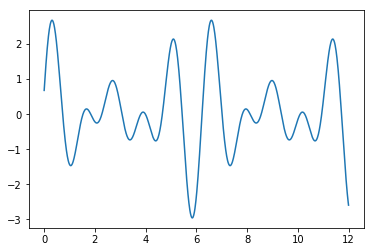

In [66]:
plt.plot(x, y)

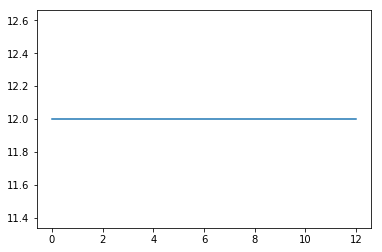

In [67]:
plt.plot(x, discount_rewards(x, 0.0))